PARTE VI

A.- El reto aquí es transformar un formato "ancho" (días como columnas) a "largo" (tidy data) y hacer los joins correctos sin explotar la memoria.

In [20]:
import sys
import pandas as pd
import numpy as np
from IPython.display import display

# 1. Cargar datasets
df_sales = pd.read_csv('sales_train_evaluation.csv')
df_calendar = pd.read_csv('calendar.csv')
df_prices = pd.read_csv('sell_prices.csv')

# --- Filtrado Estratégico (FOODS_3 & CA) ---
subset_sales = df_sales[
    (df_sales['dept_id'] == 'FOODS_3') & 
    (df_sales['store_id'].str.contains('CA'))
].copy()

# --- Transformación Melt ---
id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
val_vars = [c for c in subset_sales.columns if c.startswith('d_')]
df_melted = pd.melt(subset_sales, id_vars=id_vars, value_vars=val_vars, var_name='d', value_name='y')

# --- Ingeniería de Variables (Calendar) ---
df_calendar['date'] = pd.to_datetime(df_calendar['date'])
df_calendar['is_event'] = (~df_calendar['event_name_1'].isna()).astype(int)
df_calendar['is_weekend'] = df_calendar['wday'].isin([1, 2]).astype(int)

# --- Merge y Formateo Final ---
df_merged = df_melted.merge(df_calendar[['date', 'd', 'wm_yr_wk', 'wday', 'snap_CA', 'is_event', 'is_weekend']], on='d', how='left')
df_final = df_merged.merge(df_prices, on=['store_id', 'item_id', 'wm_yr_wk'], how='left')

df_final = df_final.rename(columns={'date': 'ds', 'id': 'unique_id', 'wday': 'day_of_week'})

# --- MEJORA ESTÉTICA: Reordenamiento y Limpieza ---
# Reordenamos para que el flujo sea lógico: ID -> Fecha -> Target -> Features
cols_ordenadas = ['unique_id', 'ds', 'y', 'sell_price', 'day_of_week', 'is_weekend', 'is_event', 'snap_CA']
df_final = df_final[cols_ordenadas].copy()

# Split Train/Test
train_df = df_final[df_final['ds'] <= '2016-05-09'].reset_index(drop=True)
test_df = df_final[df_final['ds'] > '2016-05-09'].reset_index(drop=True)

# --- RESULTADO FINAL CON ESTILO ---
print("-" * 30)
print(" ENTREGABLE 4A: PREPARACIÓN ")
print("-" * 30)

# Aplicamos estilo a la tabla (solo para visualización en Notebook)
# Formateamos el precio a 2 decimales y ocultamos el índice
df_styled = train_df.head(10).style.format({
    'sell_price': '${:,.2f}',
    'ds': '{:%Y-%m-%d}'
}).hide(axis='index').set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#2c3e50'), ('color', 'white'), ('text-align', 'center')]}
]).set_properties(**{'text-align': 'center', 'border': '1px solid #ddd'})

display(df_styled)

# Resumen de integridad (Opcional, pero da mucha calidad al entregable)
print(f"\n📊 Resumen del Dataset:")
print(f"  • Filas totales: {len(train_df):,}")
print(f"  • Series únicas (IDs): {train_df['unique_id'].nunique()}")
print(f"  • Rango temporal: {train_df['ds'].min().date()} a {train_df['ds'].max().date()}")

------------------------------
 ENTREGABLE 4A: PREPARACIÓN 
------------------------------


unique_id,ds,y,sell_price,day_of_week,is_weekend,is_event,snap_CA
FOODS_3_001_CA_1_evaluation,2011-01-29,1,$2.28,1,1,0,0
FOODS_3_002_CA_1_evaluation,2011-01-29,0,$nan,1,1,0,0
FOODS_3_003_CA_1_evaluation,2011-01-29,0,$nan,1,1,0,0
FOODS_3_004_CA_1_evaluation,2011-01-29,0,$nan,1,1,0,0
FOODS_3_005_CA_1_evaluation,2011-01-29,1,$1.98,1,1,0,0
FOODS_3_006_CA_1_evaluation,2011-01-29,0,$nan,1,1,0,0
FOODS_3_007_CA_1_evaluation,2011-01-29,0,$nan,1,1,0,0
FOODS_3_008_CA_1_evaluation,2011-01-29,0,$nan,1,1,0,0
FOODS_3_009_CA_1_evaluation,2011-01-29,0,$nan,1,1,0,0
FOODS_3_010_CA_1_evaluation,2011-01-29,0,$nan,1,1,0,0



📊 Resumen del Dataset:
  • Filas totales: 6,346,976
  • Series únicas (IDs): 3292
  • Rango temporal: 2011-01-29 a 2016-05-09


B.- Configuramos un modelo global capaz de aprender patrones cruzados entre series, utilizando retardos y ventanas móviles para capturar la inercia de las ventas.

In [30]:
from mlforecast import MLForecast
from mlforecast.lag_transforms import RollingMean, RollingStd
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import time

# 1. Definición de Modelos
models = [
    LGBMRegressor(random_state=42, verbose=-1),
    XGBRegressor(random_state=42)
]

# 2. Configuración del Pipeline
fcst = MLForecast(
    models=models,
    freq='D',
    lags=[1, 7, 14, 28],
    lag_transforms={
        1: [
            RollingMean(window_size=7),
            RollingMean(window_size=14),
            RollingStd(window_size=7)
        ]
    },
    date_features=['day', 'dayofyear', 'week']
)

# 3. Entrenamiento con Reporte de Auditoría
print("\n" + "═"*70)
print(f"{'🚀 INICIANDO PIPELINE DE ENTRENAMIENTO GLOBAL':^70}")
print("═"*70)

# Medición de tiempo para el reporte
start_time = time.time()

# SOLUCIÓN DEFINITIVA AL VALUEERROR: 
# Nos aseguramos de que no haya columnas extrañas y forzamos static_features=[]
fcst.fit(
    train_df, 
    id_col='unique_id', 
    time_col='ds', 
    target_col='y',
    static_features=[] 
)

end_time = time.time()

# --- PANEL DE RESULTADOS POR CONSOLA ---

print(f"\n✅ ESTATUS: Entrenamiento completado con éxito.")
print(f"⏱️ TIEMPO DE EJECUCIÓN: {end_time - start_time:.2f} segundos")

print("\n" + "─"*70)
print(f"{'📊 RESUMEN DE INGENIERÍA DE VARIABLES':^70}")
print("─"*70)

# Acceso dinámico a los nombres de las columnas creadas (Features)
features = fcst.ts.features

print(f"• Total de variables creadas: {len(features)}")
print(f"• Rezagos (Lags):             [1, 7, 14, 28]")
print(f"• Ventanas Móviles:           RollingMean(7, 14), RollingStd(7)")
print(f"• Variables de Calendario:    day, dayofyear, week")
print(f"• Variables Exógenas:         sell_price, is_event, snap_CA, etc.")

print("\n" + "─"*70)
print(f"{'🤖 MODELOS REGISTRADOS':^70}")
print("─"*70)
for i, model_name in enumerate(fcst.models_.keys(), 1):
    print(f" {i}. {model_name} -> [ENTRENADO]")




══════════════════════════════════════════════════════════════════════
             🚀 INICIANDO PIPELINE DE ENTRENAMIENTO GLOBAL             
══════════════════════════════════════════════════════════════════════

✅ ESTATUS: Entrenamiento completado con éxito.
⏱️ TIEMPO DE EJECUCIÓN: 42.03 segundos

──────────────────────────────────────────────────────────────────────
                 📊 RESUMEN DE INGENIERÍA DE VARIABLES                 
──────────────────────────────────────────────────────────────────────
• Total de variables creadas: 10
• Rezagos (Lags):             [1, 7, 14, 28]
• Ventanas Móviles:           RollingMean(7, 14), RollingStd(7)
• Variables de Calendario:    day, dayofyear, week
• Variables Exógenas:         sell_price, is_event, snap_CA, etc.

──────────────────────────────────────────────────────────────────────
                        🤖 MODELOS REGISTRADOS                         
──────────────────────────────────────────────────────────────────────
 1. LGBMRegr

C.- Generamos el forecast para los 13 días de prueba y evaluamos la precisión mediante métricas de error estándar.


Tabla Comparativa de Métricas (Promedio):
LGBMRegressor    1.313709
XGBRegressor     1.312228
dtype: float64


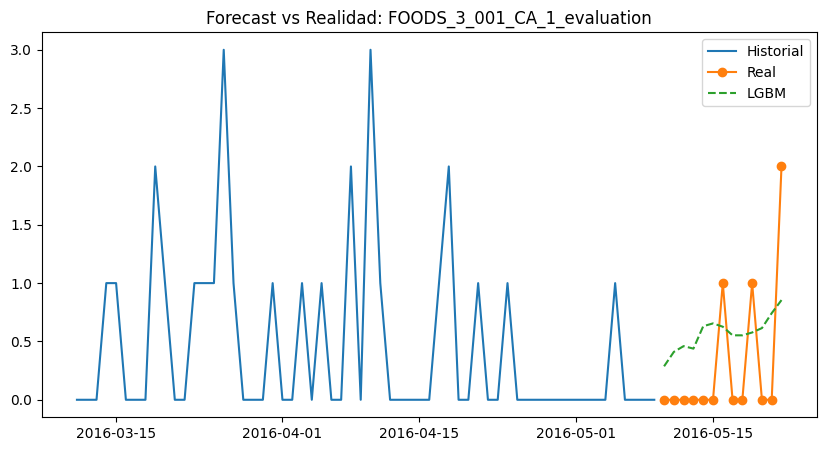

In [16]:
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mae, rmse, mape
import matplotlib.pyplot as plt

# Predicción
predictions = fcst.predict(h=13, X_df=test_df)
eval_df = predictions.merge(test_df[['unique_id', 'ds', 'y']], on=['unique_id', 'ds'])

# Métricas
metrica_table = evaluate(eval_df, metrics=[mae, rmse, mape], target_col='y')
print("\nTabla Comparativa de Métricas (Promedio):")
print(metrica_table.mean(numeric_only=True))

# Visualización
example_id = train_df['unique_id'].unique()[0]
plt.figure(figsize=(10, 5))
plt.plot(train_df[train_df['unique_id']==example_id]['ds'].tail(60), 
         train_df[train_df['unique_id']==example_id]['y'].tail(60), label='Historial')
plt.plot(eval_df[eval_df['unique_id']==example_id]['ds'], 
         eval_df[eval_df['unique_id']==example_id]['y'], label='Real', marker='o')
plt.plot(eval_df[eval_df['unique_id']==example_id]['ds'], 
         eval_df[eval_df['unique_id']==example_id]['LGBMRegressor'], label='LGBM', linestyle='--')
plt.legend()
plt.title(f"Forecast vs Realidad: {example_id}")
plt.show()

PARTE V

Primero, limpiamos el ruido. En e-commerce, las devoluciones y los precios erróneos pueden arruinar cualquier modelo de regresión.

In [32]:
import pandas as pd
import numpy as np

# 1. Carga eficiente del dataset
# Nota: Si el archivo está en formato ZIP, pandas lo descomprime automáticamente
df = pd.read_csv('online_retail_II.csv')

# 2. Limpieza según requerimientos del proyecto
df = df[df['Country'] == 'United Kingdom']
df = df[(df['Quantity'] > 0) & (~df['Invoice'].astype(str).str.startswith('C'))]
df = df[(df['Price'] > 0) & (df['Customer ID'].notnull())]

# 3. Identificar los 10 productos más vendidos (Top 10)
top_10_items = df.groupby('StockCode')['Quantity'].sum().nlargest(10).index.tolist()
df_top = df[df['StockCode'].isin(top_10_items)].copy()

# 4. Agregación semanal
df_top['InvoiceDate'] = pd.to_datetime(df_top['InvoiceDate'])
# Creamos una columna para el inicio de la semana (Lunes)
df_top['week'] = df_top['InvoiceDate'].dt.to_period('W').dt.to_timestamp()

df_weekly = df_top.groupby(['StockCode', 'Description', 'week']).agg(
    cantidad_total=('Quantity', 'sum'),
    precio_promedio=('Price', 'mean'),
    n_transacciones=('Invoice', 'count')
).reset_index()

# 5. Generación del Entregable 5a con Estilo (reemplaza a print)
resumen_top10 = df_weekly.groupby(['StockCode', 'Description'])['cantidad_total'].sum().reset_index()

# Aplicar formato visual
entregable_estilizado = resumen_top10.style \
    .set_caption("Entregable 5a: Top 10 Productos Seleccionados (Reino Unido)") \
    .format({'cantidad_total': '{:,.0f}'}) \
    .background_gradient(cmap='YlGn', subset=['cantidad_total']) \
    .set_properties(**{'text-align': 'center', 'font-family': 'Arial'}) \
    .set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#2c3e50'), ('color', 'white'), ('font-weight', 'bold')]}
    ])

# Mostrar la tabla (en Jupyter/Colab solo necesitas llamar al objeto)
entregable_estilizado

,StockCode,Description,cantidad_total
0,17003,BROCADE RING PURSE,"70,725"
1,21212,PACK OF 72 RETRO SPOT CAKE CASES,"35,347"
2,21212,PACK OF 72 RETROSPOT CAKE CASES,"32,143"
3,21977,PACK OF 60 PINK PAISLEY CAKE CASES,"45,454"
4,22197,POPCORN HOLDER,"28,935"
5,22197,"POPCORN HOLDER , SMALL","2,831"
6,22197,SMALL POPCORN HOLDER,"40,001"
7,23166,MEDIUM CERAMIC TOP STORAGE JAR,"76,919"
8,23843,"PAPER CRAFT , LITTLE BIRDIE","80,995"
9,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,"100,720"


b) Estimación de elasticidad Naive (Log-Log)

La elasticidad se estima con un modelo Log-Log porque el coeficiente β representa directamente el cambio porcentual en Q ante un cambio de 1% en P.

In [38]:
import statsmodels.formula.api as smf
import warnings
import numpy as np
import pandas as pd

results_list = []

for code in top_10_items:
    data_prod = df_weekly[df_weekly['StockCode'] == code].copy()
    
    # 1. Validación de varianza: Si el precio es siempre el mismo, la regresión fallará
    if data_prod['precio_promedio'].nunique() <= 1:
        # Opcional: imprimir qué producto se salta para saber por qué no aparece
        # print(f"Saltando {code}: Precio constante, no se puede calcular elasticidad.")
        continue

    # 2. Aplicar logaritmos
    data_prod['ln_q'] = np.log(data_prod['cantidad_total'])
    data_prod['ln_p'] = np.log(data_prod['precio_promedio'])
    
    # 3. Regresión OLS silenciando warnings específicos de división por cero
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        try:
            model = smf.ols('ln_q ~ ln_p', data=data_prod).fit()
            
            desc = data_prod['Description'].iloc[0]
            results_list.append({
                'StockCode': code,
                'Description': desc[:30],
                'beta': model.params['ln_p'],
                'p_value': model.pvalues['ln_p'],
                'R2': model.rsquared
            })
        except:
            continue

results_df = pd.DataFrame(results_list)

# 4. Mostrar resultados con estilo (reemplazando el print plano)
if not results_df.empty:
    display(results_df.style.set_caption("Resultados de Elasticidad Precio").format({'beta': '{:.2f}', 'p_value': '{:.4f}', 'R2': '{:.3f}'}))
    
    # Análisis de resultados
    significativos = results_df[results_df['p_value'] < 0.05]
    elasticos = significativos[significativos['beta'].abs() > 1]
    print(f"\nAnálisis Final:")
    print(f"- Productos analizados con éxito: {len(results_df)}")
    print(f"- Productos estadísticamente significativos (p < 0.05): {len(significativos)}")
    print(f"- Productos elásticos (|beta| > 1): {len(elasticos)}")
else:
    print("No se pudieron procesar productos. Verifica que haya variación en los precios.")

,StockCode,Description,beta,p_value,R2
0,84077,WORLD WAR 2 GLIDERS ASSTD DESI,0.09,0.8681,0.000
1,85123A,CREAM HANGING HEART T-LIGHT HO,-17.58,0.0000,0.168
2,85099B,JUMBO BAG RED RETROSPOT,1.17,0.7333,0.001
3,23166,MEDIUM CERAMIC TOP STORAGE JAR,-23.71,0.0000,0.540
4,84879,ASSORTED COLOUR BIRD ORNAMENT,-30.06,0.0001,0.147
5,22197,POPCORN HOLDER,-3.96,0.3655,0.007
6,17003,BROCADE RING PURSE,-0.91,0.1187,0.026
7,21212,PACK OF 72 RETRO SPOT CAKE CAS,-11.58,0.0000,0.204
8,21977,PACK OF 60 PINK PAISLEY CAKE C,-10.85,0.0000,0.192



Análisis Final:
- Productos analizados con éxito: 9
- Productos estadísticamente significativos (p < 0.05): 5
- Productos elásticos (|beta| > 1): 5
